In [11]:
# 기본 데이터 처리 라이브러리
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# 텍스트 시각화 라이브러리
from wordcloud import WordCloud

# 자연어 처리를 위한 NLTK 라이브러리
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # 영어 불용어 사전 다운로드

# Scikit-learn 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Keras/TensorFlow 라이브러리
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
# 데이터셋 불러오기
try:
    df = pd.read_csv('/content/tripadvisor_hotel_reviews.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: 'hotel_reviews.csv' not found. Please make sure the file is in the correct directory.")

# 필요한 컬럼(Review, Rating)만 선택 및 결측치 제거
df = df[['Review', 'Rating']].dropna()

# Rating을 정수형으로 변환
df['Rating'] = df['Rating'].astype(int)

print(f"전체 리뷰 개수: {len(df)}")
df.head()

Data loaded successfully!
전체 리뷰 개수: 20491


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


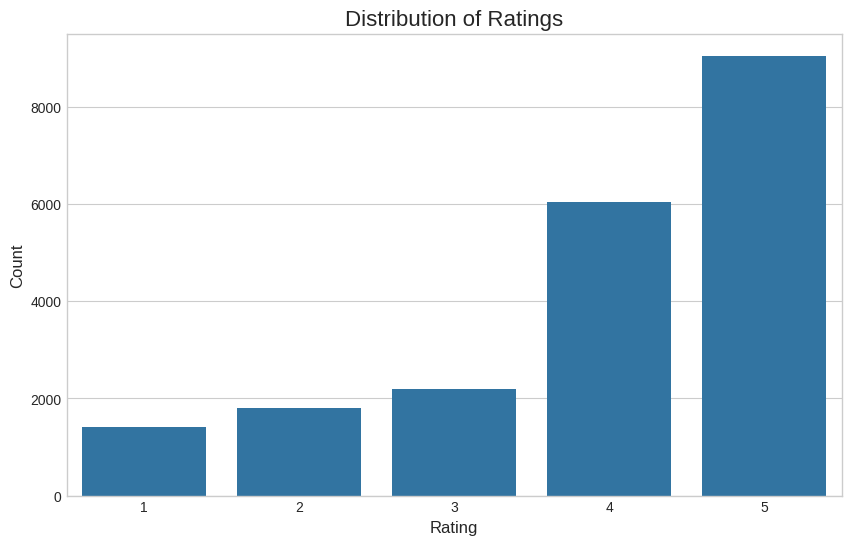

In [14]:
# 별점(Rating) 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', data=df)
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

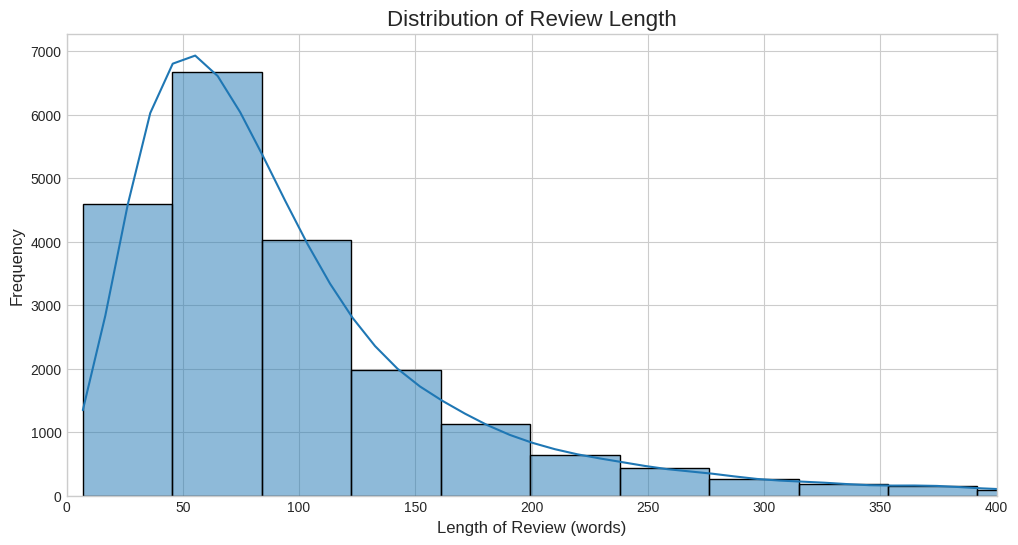

리뷰 최대 길이: 1931
리뷰 평균 길이: 104.38


In [15]:
# 각 리뷰의 길이(단어 개수)를 계산
df['length'] = df['Review'].apply(lambda x: len(str(x).split()))

# 리뷰 길이 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(df['length'], bins=50, kde=True)
plt.title('Distribution of Review Length', fontsize=16)
plt.xlabel('Length of Review (words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0, 400) # 길이 범위를 제한하여 보기 쉽게
plt.show()

print(f"리뷰 최대 길이: {df['length'].max()}")
print(f"리뷰 평균 길이: {df['length'].mean():.2f}")

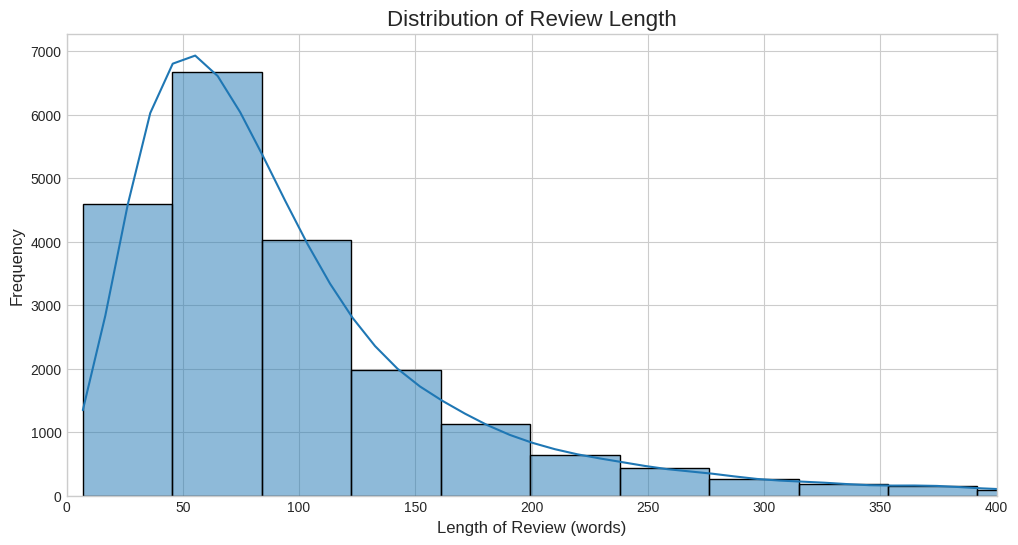

리뷰 최대 길이: 1931
리뷰 평균 길이: 104.38


In [16]:
# 각 리뷰의 길이(단어 개수)를 계산
df['length'] = df['Review'].apply(lambda x: len(str(x).split()))

# 리뷰 길이 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(df['length'], bins=50, kde=True)
plt.title('Distribution of Review Length', fontsize=16)
plt.xlabel('Length of Review (words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0, 400) # 길이 범위를 제한하여 보기 쉽게
plt.show()

print(f"리뷰 최대 길이: {df['length'].max()}")
print(f"리뷰 평균 길이: {df['length'].mean():.2f}")

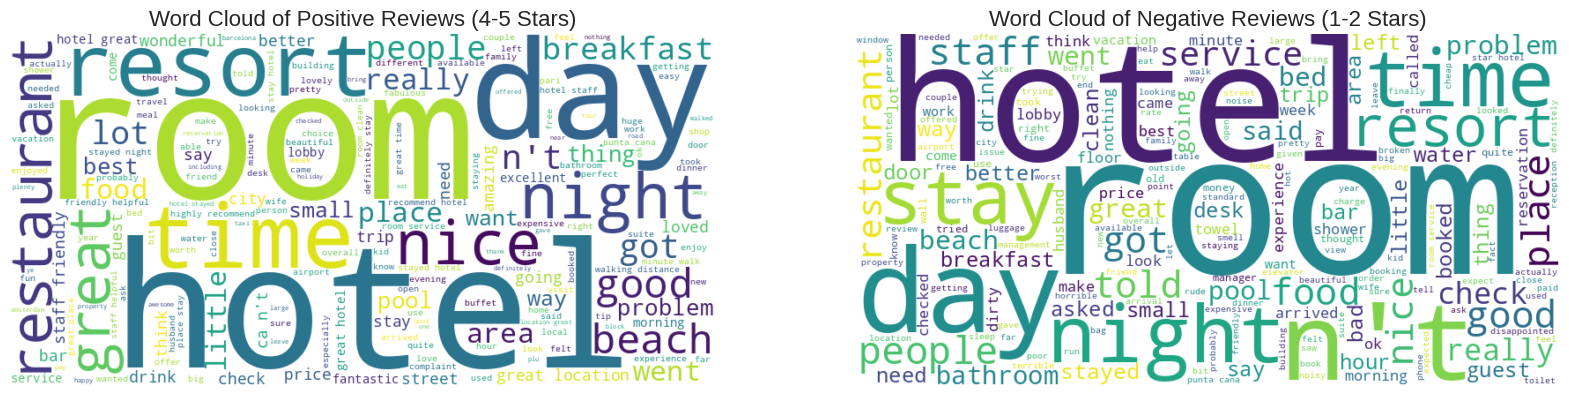

In [17]:
# 긍정(4, 5점) / 부정(1, 2점) 리뷰 분리
positive_reviews = ' '.join(df[df['Rating'] >= 4]['Review'].astype(str).tolist())
negative_reviews = ' '.join(df[df['Rating'] <= 2]['Review'].astype(str).tolist())

# 워드 클라우드 생성
wc_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
wc_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# 워드 클라우드 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(wc_pos, interpolation='bilinear')
ax1.set_title('Word Cloud of Positive Reviews (4-5 Stars)', fontsize=16)
ax1.axis('off')

ax2.imshow(wc_neg, interpolation='bilinear')
ax2.set_title('Word Cloud of Negative Reviews (1-2 Stars)', fontsize=16)
ax2.axis('off')

plt.show()

In [18]:
# 1. 텍스트 정제: 알파벳과 공백을 제외한 모든 문자 제거 및 소문자 변환
df['Review_cleaned'] = df['Review'].str.replace("[^a-zA-Z ]","", regex=True).str.lower()

# 2. 토큰화 (단어 단위로 분리)
df['tokens'] = df['Review_cleaned'].apply(lambda x: str(x).split())

# 3. 영어 불용어 제거
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words and len(word) > 2])

df.head()

,Review,Rating,length,Review_cleaned,tokens
0,nice hotel expensive parking got good deal sta...,4,87,nice hotel expensive parking got good deal sta...,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,2,250,ok nothing special charge diamond member hilto...,"[nothing, special, charge, diamond, member, hi..."
2,nice rooms not 4* experience hotel monaco seat...,3,217,nice rooms not experience hotel monaco seattl...,"[nice, rooms, experience, hotel, monaco, seatt..."
3,"unique, great stay, wonderful time hotel monac...",5,89,unique great stay wonderful time hotel monaco ...,"[unique, great, stay, wonderful, time, hotel, ..."
4,"great stay great stay, went seahawk game aweso...",5,191,great stay great stay went seahawk game awesom...,"[great, stay, great, stay, went, seahawk, game..."


In [19]:
# Tokenizer를 사용하여 단어를 정수 인덱스로 변환
# 데이터의 90%만 사용하여 단어 사전 생성 (나머지는 OOV(Out-of-Vocabulary) 처리 연습)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tokens'].values[:int(len(df)*0.9)])

# 단어 사전의 크기 확인
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 # 패딩을 위한 0을 고려하여 +1
print(f"단어 사전(Vocabulary) 크기: {vocab_size}")

# 텍스트를 정수 시퀀스로 변환
sequences = tokenizer.texts_to_sequences(df['tokens'].values)

# 패딩 처리
MAX_LEN = 100 # 리뷰 최대 길이를 참고하여 설정
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# 별점(Rating)을 0~4 범위로 조정 (모델 출력에 맞게)
y = df['Rating'].values - 1

단어 사전(Vocabulary) 크기: 68669


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, y, test_size=0.2, random_state=42, stratify=y
)

print(f"학습 데이터 모양: {X_train.shape}")
print(f"테스트 데이터 모양: {X_test.shape}")

학습 데이터 모양: (16392, 100)
테스트 데이터 모양: (4099, 100)


In [21]:
EMBEDDING_DIM = 128
HIDDEN_UNITS = 128

model = Sequential([
    Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(HIDDEN_UNITS, return_sequences=True)),
    Bidirectional(LSTM(HIDDEN_UNITS)),
    Dropout(0.5),
    Dense(5, activation='softmax') # 5개의 별점을 분류
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

205/205 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.4968 - loss: 1.1784 - val_accuracy: 0.6173 - val_loss: 0.8878
Restoring model weights from the end of the best epoch: 1.


In [ ]:
# 학습 과정의 손실 및 정확도 변화 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Loss plot
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss Over Epochs', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()

# Accuracy plot
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Model Accuracy Over Epochs', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend()

plt.show()

In [25]:
# 테스트 데이터셋에 대한 예측
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report 출력
class_names = ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']
print("--- Classification Report ---\n")
print(classification_report(y_test, y_pred, target_names=class_names))

129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step
--- Classification Report ---

              precision    recall  f1-score   support

      1 Star       0.47      0.81      0.59       284
     2 Stars       0.36      0.16      0.22       359
     3 Stars       0.36      0.20      0.25       437
     4 Stars       0.52      0.51      0.52      1208
     5 Stars       0.72      0.81      0.76      1811

    accuracy                           0.60      4099
   macro avg       0.49      0.50      0.47      4099
weighted avg       0.57      0.60      0.58      4099



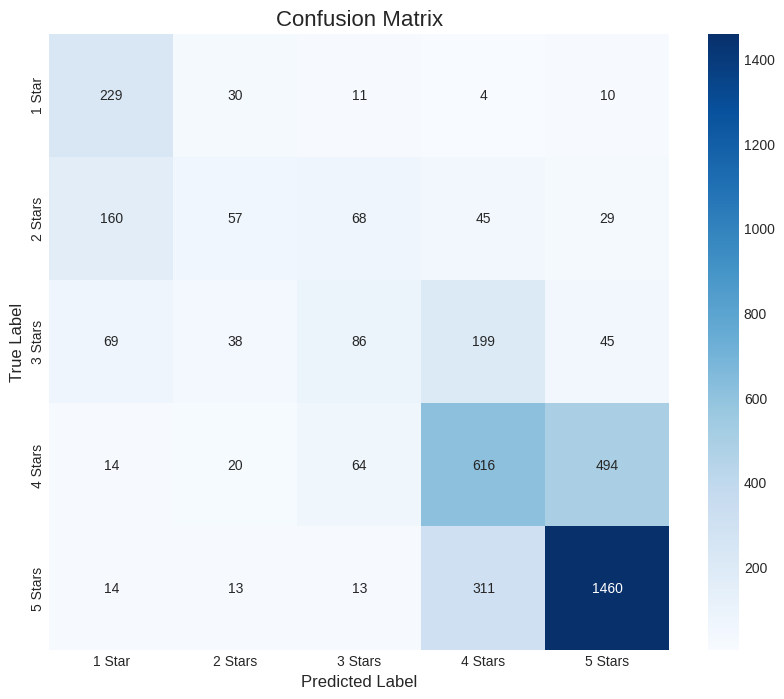

In [26]:
# 혼동 행렬(Confusion Matrix) 시각화
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()